<center>
    <p style="text-align:center">
        <img alt="arize llama-index logos" src="https://storage.googleapis.com/arize-assets/phoenix/assets/docs/notebooks/llama-index-knowledge-base-tutorial/arize_llamaindex.png" width="400">
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Evaluating and Improving a LlamaIndex Search and Retrieval Application using Milvus as a Vector Store</h1>

Imagine you're an engineer at Arize AI and you've built and deployed a documentation question-answering service using LlamaIndex. Users send questions about Arize's core product via a chat interface, and your service retrieves documents from your documentation in order to generate a response to the user. As the engineer in charge of evaluating and maintaining this system, you want to evaluate the quality of the responses from your service.

Phoenix helps you:
- identify gaps in your documentation
- detect queries for which the LLM gave bad responses
- detect failures to retrieve relevant context

In this tutorial, you will:

- Create a vector store from a json file and set it up with Milvus Lite
- Download a pre-indexed knowledge base of the Arize documentation and run a LlamaIndex application
- Visualize user queries and knowledge base documents to identify areas of user interest not answered by your documentation
- Find clusters of responses with negative user feedback
- Identify failed retrievals using cosine similarity, Euclidean distance, and LLM-assisted ranking metrics

Parts of this notebook require an [OpenAI API key](https://platform.openai.com/account/api-keys) to run. If you don't have an OpenAI key, you can still run Phoenix by skipping cells preceded by the 💭 emoji.


## Chatbot Architecture

Your chatbot was built using LlamaIndex's low-level API. The architecture of your chatbot is shown below and can be explained in five steps.

![llama-index chatbot architecture](http://storage.googleapis.com/arize-assets/phoenix/assets/docs/notebooks/llama-index-knowledge-base-tutorial/llama_index_chatbot_architecture.png)

1. The user sends a query about Arize to your service.
1. `langchain.embeddings.OpenAIEmbeddings` makes a request to the OpenAI embeddings API to embed the user query using the `text-embedding-ada-002` model.
1. `llama_index.retrievers.RetrieverQueryEngine` does a similarity search against the entries of your index knowledge base for the two most similar pieces of context by cosine similarity.
1. `llama_index.indices.query.ResponseSynthesizer` generates a response by formatting the query and retrieved context into a single prompt and sending a request to OpenAI chat completions API with the `gpt-3.5-turbo`.
2. The response is returned to the user.

Phoenix makes your search and retrieval system *observable* by capturing the inputs and outputs of these steps for analysis, including:

- your query embeddings
- the retrieved context and similarity scores for each query
- the generated response that is return to the user

With that overview in mind, let's dive into the notebook.

### Necessary set up

First we'll install Phoenix, milvus, pymilvus and llama-index

In [1]:
!pip install pymilvus
!pip install milvus
!pip install gcsfs llama-index
!pip install -q "arize-phoenix[experimental]"

Import the necessary libraries

In [2]:
import json
import pandas as pd
import hashlib
import logging
import os
import sys
import tempfile
import textwrap
import numpy as np
import numpy.typing as npt
import openai
import numpy as np
import phoenix as px
import urllib
import zipfile

from gcsfs import GCSFileSystem
from llama_index import StorageContext, load_index_from_storage
from llama_index.graph_stores.simple import SimpleGraphStore
from llama_index.vector_stores import MilvusVectorStore, SimpleVectorStore
from llama_index import SimpleDirectoryReader
from llama_index import VectorStoreIndex, Document
from llama_index.callbacks import CallbackManager, OpenInferenceCallbackHandler
from llama_index.callbacks.open_inference_callback import as_dataframe
from llama_index.embeddings.base import BaseEmbedding
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.indices.query.schema import QueryBundle
from llama_index.query_engine import RetrieverQueryEngine
from llama_index.response.schema import Response
from llama_index import ServiceContext, LLMPredictor
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.response.schema import Response
from datetime import timedelta
from IPython.display import YouTubeVideo

from functools import reduce

from tqdm import tqdm
from typing import Any, Dict, List, Tuple


from langchain.chat_models import ChatOpenAI


from milvus import default_server
from pymilvus import (
    connections,
    FieldSchema,
    CollectionSchema,
    DataType,
    Collection,
    utility,
)

from phoenix.experimental.evals.retrievals import (
    classify_relevance,
    compute_precisions_at_k,
)
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)


pd.set_option("display.max_colwidth", 1000)



And set up our openai api key

In [3]:
openai_api_key = "place your openai api key here"
assert openai_api_key == "place your openai api key here", "❌ Please set your OpenAI API key"
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

For this example in particular we'll be using a json file to generate the necessary data to build our vector store

In [4]:
with open("dataset.json", "r") as file:
    data = json.load(file)

    rows = data['rows']
    for row in rows:
        if isinstance(row['node'], dict):
            row['node'] = json.dumps(row['node'])

### Milvus lite llama index integration and query testing

To create a vector store to work with, we'll instantiate milvus lite default server.
In order to have it running we need the following steps:

1. create and define fields to be used in our Milvus collection.
2. Define a schema with set fields.
3. Format the ingest data from a JSON file, dataframe, etc for Milvus readability.
4. Create a collection with a new name and assigning the previously created schema to it.
5. Insert the data.

Afterwards and with the milvus instance running, start a LlamaIndex application from your downloaded index. Use the OpenInferenceCallbackHandler to store your data in OpenInference format, an open standard for capturing and storing AI model inferences that enables production LLMapp servers to seamlessly integrate with LLM observability solutions such as Arize and Phoenix.

And finally ask a few questions of your question-answering service and view the responses.

Please double check your internet connection as this may result in the following error: TimeoutError: Milvus not startd in 30.0 seconds

In [5]:
with default_server:
    connections.connect(host='localhost', port=default_server.listen_port)
    collection_name = 'colab_collection'

    # define your fields
    fields = [
        FieldSchema(name="id", dtype=DataType.VARCHAR, is_primary=True, auto_id=False, max_length=65535),
        FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=1536),
        FieldSchema(name="doc_id", dtype=DataType.VARCHAR, max_length=65535),
        FieldSchema(name="text", dtype=DataType.VARCHAR, max_length=65535),
        FieldSchema(name="node", dtype=DataType.VARCHAR, max_length=65535),
    ]

    # define your schema
    schema = CollectionSchema(fields=fields, description="this is a collection basedc on arize docs")

    # Transform the data into the format needed for the insert operation
    insert_data = [
        [record[field.name] for record in rows] for field in schema.fields
    ]
    # create your collection
    collection = Collection(name=collection_name, schema=schema)

    # Insert the data into the collection
    mr = collection.insert(insert_data)

    file_system = GCSFileSystem(project="public-assets-275721")
    index_path = "arize-assets/phoenix/datasets/unstructured/llm/llama-index/arize-docs/index/"
    vector_store = MilvusVectorStore(
        host='localhost', 
        port=default_server.listen_port,
        collection_name="colab_collection",
        overwrite='False'
    )
    
    storage_context = StorageContext.from_defaults(
        fs=file_system,
        persist_dir=index_path,
        graph_store=SimpleGraphStore(),
        vector_store = vector_store
    )

    callback_handler = OpenInferenceCallbackHandler()
    service_context = ServiceContext.from_defaults(
        llm_predictor=LLMPredictor(llm=ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)),
        embed_model=OpenAIEmbedding(model="text-embedding-ada-002"),
        callback_manager=CallbackManager(handlers=[callback_handler]),
    )
    
    index = load_index_from_storage(
        storage_context,
        service_context=service_context,
    )
    
    query_engine = index.as_query_engine()
    
    max_line_length = 80
    for query in [
        "How do I get an Arize API key?",
        "Can I create monitors with an API?",
        "How do I need to format timestamps?",
        "What is the price of the Arize platform",
    ]:
        print("Query")
        print("=====")
        print()
        print(textwrap.fill(query, max_line_length))
        print()
        response = query_engine.query(query)
        print("Response")
        print("========")
        print()
        print(textwrap.fill(str(response), max_line_length))
        print()



    __  _________ _   ____  ______
   /  |/  /  _/ /| | / / / / / __/
  / /|_/ // // /_| |/ / /_/ /\ \
 /_/  /_/___/____/___/\____/___/ {Lite}

 Welcome to use Milvus!

 Version:   v2.2.12-lite
 Process:   7336
 Started:   2023-08-08 12:05:41
 Config:    /home/ruiciro/.milvus.io/milvus-server/2.2.12/configs/milvus.yaml
 Logs:      /home/ruiciro/.milvus.io/milvus-server/2.2.12/logs

 Ctrl+C to exit ...
Query
=====

How do I get an Arize API key?

Response

To get an Arize API key, you need to click the 'Get Your API Key' button on the
top right of the Explorer page.

Query
=====

Can I create monitors with an API?

Response

Yes, you can create monitors with an API using the public-facing graphQL API
provided.

Query
=====

How do I need to format timestamps?

Response

You can format timestamps in either seconds or using the RFC3339 timestamp
format. If you do not specify a timestamp, it will default to the time of file
ingestion.

Query
=====

What is the price of the Arize platform

### Loading data into dataframes


To use Phoenix, you must load your data into pandas dataframes.

Your query data is saved in a buffer on the callback handler you defined previously. Load the data from the buffer into a dataframe.


In [6]:
query_data_buffer = callback_handler.flush_query_data_buffer()
sample_query_df = as_dataframe(query_data_buffer)
list_of_document_id_lists = sample_query_df[":feature.[str].retrieved_document_ids:prompt"].tolist()

In [7]:
query_df = pd.read_parquet(
    "http://storage.googleapis.com/arize-assets/phoenix/datasets/unstructured/llm/llama-index/arize-docs/query_data_complete3.parquet",
)
query_df.head()

,:feature.text:prompt,:feature.[float].embedding:prompt,:prediction.text:response,:tag.float:document_similarity_0,:tag.float:document_similarity_1,:tag.float:user_feedback,:feature.[str].retrieved_document_ids:prompt,:feature.[float].retrieved_document_scores:prompt,:tag.str:openai_relevance_0,:tag.str:openai_relevance_1,:timestamp.iso_8601:,:id.id:
0,How do I use the SDK to upload a ranking model?,"[-0.009536871686577797, 0.008512362837791443, 0.013284236192703247, -0.0024701666552573442, 0.009846286848187447, 0.02992391213774681, -0.019211260601878166, -0.019087495282292366, 0.005610733292996883, -0.03492956608533859, 0.02467072568833828, -0.013057331554591656, -0.016777193173766136, -0.01948629692196846, -0.022594204172492027, -0.00867738388478756, 0.013456134125590324, 0.003432792378589511, 0.008017297834157944, 0.0022381050512194633, -0.016515908762812614, 0.017973599955439568, 0.000521708803717047, -0.014439387246966362, -0.011668399907648563, 0.015250743366777897, 0.021700337529182434, -0.01339425053447485, 0.01630963198840618, 0.002007762435823679, 0.001018492504954338, 0.011455247178673744, -0.021095257252454758, -0.008017297834157944, -0.018331145867705345, 0.012892310507595539, -0.009103690274059772, 0.008443604223430157, 0.01030009612441063, -0.02304801344871521, 0.020943988114595413, 0.018523670732975006, 0.0022191964089870453, -0.022319167852401733, -0.0044762101...","\nTo use the SDK to upload a ranking model, you will need to first install the SDK and then use the SDK's upload_model() method. This method takes the model name, model type, and model data as parameters. For the 'arize-demo-hotel-ranking' model, the model type should be set to 'ranking' and the model data should be the JSON file containing the model's configuration. Once the model is uploaded, you can use the SDK's evaluate_model() method to evaluate the model's performance.",0.802402,0.796486,-1.0,"[096f842ed9e4be0a4d61c7e7b3ac9b54d88fa02ebcf1fbe4cc93cc161c84246f, 98797bdfd3ea9102fe5438559c80b04571a95a5f57f3005b60f0e0a60cabcb8b]","[0.8024018669959406, 0.7964861566463088]",irrelevant,irrelevant,2023-07-26T02:00:23.228836,f24c0bad-444f-47da-98d2-0c5ca48fb447
1,What drift metrics are supported in Arize?,"[-0.009346794337034225, -0.00042854511411860585, -0.0009247552370652556, -0.017379986122250557, -0.0047960965894162655, 0.030313927680253983, -0.016629355028271675, 0.006423665676265955, -0.027657851576805115, -0.017495466396212578, 0.01267410907894373, 0.019270997494459152, -0.01836157962679863, -0.005113671068102121, -0.01797182857990265, 0.005756037775427103, 0.0026596863754093647, 0.003597974544391036, 0.02191263996064663, -0.006073612254112959, -0.015792112797498703, -0.017293374985456467, -0.003929984290152788, 0.008646687492728233, -0.011115106754004955, 0.0181161817163229, 0.01463007926940918, -0.005117279943078756, 0.015128093771636486, -0.02220134437084198, 0.04408511146903038, 0.027499062940478325, -0.00033742288360372186, 0.014211458154022694, -0.034817710518836975, -0.011475986801087856, 0.007636222988367081, 0.020497988909482956, 0.028119778260588646, -0.011779126711189747, 0.0045903949066996574, -0.017235632985830307, 0.0013929972192272544, -0.005752428900450468, 0.0...","\nArize supports drift metrics such as Population Stability Index, KL Divergence, and Wasserstein Distance.",0.876875,0.873443,NaN,"[4ba270d946086c744bf09cbb8ceaf5180803458c9f6d5f2531dcdcda0991538b, b40b5c5c61d22f0599e00702092bd4966a01689922311c647f2127fb39720c84]","[0.8768752151560731, 0.873443430009533]",irrelevant,relevant,2023-07-26T02:00:23.228836,cb25d0e4-846c-430c-b029-71c2cd3fea6d
2,Does Arize support batch models?,"[-0.016511010006070137, -0.000836528604850173, -0.016215920448303223, -0.007496701553463936, 0.0061793336644768715, 0.018225345760583878, 0.026698654517531395, 0.0029333392158150673, -0.008684088476002216, -0.035551365464925766, 0.007904207333922386, 0.025855539366602898, 0.0010196426883339882, -0.008346842601895332, -0.01403084583580494, 0.004577



In addition to the columns of the previous dataframe, this data has a few additional fields:

    :tag.float:user_feedback: approval or rejection from the user (-1 means thumbs down, +1 means thumbs up)
    :tag.str:openai_relevance_0: a binary classification (relevant vs. irrelevant) by GPT-4 predicting whether the first retrieved document is relevant to the query
    :tag.str:openai_relevance_1: a binary classification (relevant vs. irrelevant) by GPT-4 predicting whether the second retrieved document is relevant to the query

We'll go over how to compute the relevance classifications in section 6.

Next load your knowledge base into a dataframe.

It is important to remember as we use a milvus vector store, that the connection to the collection needs to be instantiated before being able to query from it.

# Getting info from the vector store and setting it into a dataframe

In [8]:
from pymilvus import Milvus
import numpy as np
def storage_context_to_dataframe(storage_context: StorageContext) -> pd.DataFrame:
    """Converts the storage context to a pandas dataframe.

    Args:
        storage_context (StorageContext): Storage context containing the index
        data.

    Returns:
        pd.DataFrame: The dataframe containing the index data.
    """
    document_ids = []
    document_texts = []
    document_embeddings = []
    with default_server:
        connections.connect(host='localhost', port=default_server.listen_port)
        collection_name = 'colab_collection'
        collection = Collection(collection_name)
        collection.load()
        docstore = storage_context.docstore
        vector_store = storage_context.vector_store
        for node_id, node in docstore.docs.items():
            document_ids.append(node.hash)  # use node hash as the document ID
            document_texts.append(node.text)
            expression = "doc_id=='" + str(node_id) + "'"
            vectors = collection.query(expr=expression, output_fields=['id', 'embedding', 'text', 'node'])
            document_embeddings.append(np.array(vectors[0]['embedding']))
        return pd.DataFrame(
            {
                "document_id": document_ids,
                "text": document_texts,
                "text_vector": document_embeddings,
            }
        )
        

database_df = storage_context_to_dataframe(storage_context)
database_df = database_df.drop_duplicates(subset=["text"])

database_df.head()



    __  _________ _   ____  ______
   /  |/  /  _/ /| | / / / / / __/
  / /|_/ // // /_| |/ / /_/ /\ \
 /_/  /_/___/____/___/\____/___/ {Lite}

 Welcome to use Milvus!

 Version:   v2.2.12-lite
 Process:   7990
 Started:   2023-08-08 12:06:34
 Config:    /home/ruiciro/.milvus.io/milvus-server/2.2.12/configs/milvus.yaml
 Logs:      /home/ruiciro/.milvus.io/milvus-server/2.2.12/logs

 Ctrl+C to exit ...


,document_id,text,text_vector
0,86dacab3db386524f430c7dcdb08d55a580bc705630861bb9ce7b255d1df9d59,\nAccess tutorials of what's possible with Arize below:\n\n1. Model Type Examples\n2. Explainability Tutorials\n3. Cloud Storage Examples\n\n,"[-0.00097384764, 0.0008748269, 0.012771095, -0.002474658, 0.0067885187, 0.011021441, 0.016849028, -0.013322167, -0.01576066, -0.048632108, 0.0020492992, 0.0037197364, -0.023158804, 0.00039328463, -0.0033615394, -0.0017617085, 0.0039126114, 0.013914569, 0.032072395, -0.021478033, -0.016173964, -0.012392233, -0.021781122, -0.015168258, 0.0011589734, 0.023489445, 0.024426268, -0.0200728, 0.008507174, -0.014768731, 0.026547896, 0.014038561, 0.013659699, -0.042790744, -0.005744926, 0.0018064831, 0.028173558, 0.02231842, 0.003936721, -0.010649468, 0.033257198, -0.016036198, 0.00071553263, 0.0050113117, -0.0070606107, 0.011620732, -0.0042673643, -0.005741482, -0.00934756, -0.028104674, 0.010470369, 0.013866351, -0.02528043, 0.0049079857, -0.0043259156, 0.01137275, -0.00628911, 0.028765962, -0.005538274, 0.011042106, 0.0034820866, 0.00023851087, -0.025652405, -0.001306213, -0.014134998, 0.013721694, -0.014713624, 0.016642377, -0.005004423, 0.00385406, 0.026079485, 0.0079561025, -0.00487354..."
1,a909d43e39685381fca64b936735b972fd1433137148bda0a5f7e43f17d51c61,"\n{% hint style=""info"" %}\nYour model type determines which performance metrics are available to you. Learn more about model types here.\n{% endhint %}\n\nModel TypePandas BatchPython Single RecordCSVParquet Binary Classification (Only Classification Metrics)Colab LinkColab LinkDownload File*Open Parquet Reader HereBinary Classification (Classification, AUC/Log Loss Metrics) Colab LinkColab LinkDownload File*Open Parquet Reader HereBinary Classification (Classification, AUC/Log Loss, Regression) Colab LinkColab LinkDownload FileDownload File*Open Parquet Reader HereMulticlass Classification (Only Classification Metrics)Colab LinkColab LinkDownload File*Open Parquet Reader HereMulticlass Classification (Classification, AUC/Log Loss Metrics)Colab LinkColab LinkDownload File*Open Parquet Reader HereRegressionColab LinkColab LinkDownload FileDownload File*Open Parquet Reader HereTimeseries Forecasting Colab LinkColab LinkDownload File*Open Parquet Reader HereRanking with Relevance Scor...","[-0.0080548255, -0.0004282143, 0.026454031, -0.036494978, 0.0010327141, 0.021709409, 0.004248093, -0.012309814, -0.025460972, -0.025585104, 0.006441102, 0.04766691, -0.031971037, -0.010123702, -0.031143485, -0.015682083, 0.018399207, -0.004030861, 0.029102193, -0.0045239427, -0.0022412827, 0.011978794, -0.0220956, -0.015240722, -0.024495495, 0.01143399, 0.034067497, -0.028178096, -0.00022111116, -0.0018671609, 0.008937546, 0.015930347, -0.024261024, -0.036467392, -0.0142338695, -0.0030291798, 0.016357915, 0.008565148, 0.016026895, -0.0027309167, 0.0069755614, 0.004792897, 0.00758588, -0.0046170424, 0.01913021, 0.024757553, 0.0015128658, 0.010668506, 0.013875264, -0.0055997586, 0.018771606, 0.0062238695, -0.021916296, 0.0026998837, 0.0041067195, -0.014468342, 0.012799448, 0.021571483, -0.001844748, -0.014716607, 0.019833628, -0.0110684885, -0.0145648895, 0.005179087, 0.004882548, -0.015792422, -0.012385673, 0.017516486, -0.00083832594, 0.018992284, 0.011833972, -0.0022309383, -0.009..."
2,502dd0091ad54150572de676675430d735c3273989275f0018a94d0fa59570e5,\nExamples for logging explainability metrics. Click here for more information on how to log feature importance and use explainability.\n\n| SHAP: Guide to Getting Started | Colab Link |\n| ------------------------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |\n| SHAP: Neural Network on Tabular Data | Colab Link |\n| Surrogate Model Explainability | Colab Link |\n| One Hot Encoding Decomposition | Colab Link |\n\n,"[-0.001461149, -0.006545685, 0.033730917, -0.037505005, 

The columns of your dataframe are:

- **document_id:** the ID of the chunked document
- **text:** the chunked text in your knowledge base
- **text_vector:** the embedding vector for the text, computed during the LlamaIndex build using "text-embedding-ada-002" from OpenAI

The query and database datasets are drawn from different distributions; the queries are short questions while the database entries are several sentences to a paragraph. The embeddings from OpenAI's "text-embedding-ada-002" capture these differences and naturally separate the query and context embeddings into distinct regions of the embedding space. When using Phoenix, you want to "overlay" the query and context embedding distributions so that queries appear close to their retrieved context in the Phoenix point cloud. To achieve this, we compute a centroid for each dataset that represents an average point in the embedding distribution and center the two distributions so they overlap.

In [9]:
database_embedding_column_name = "text_vector"
database_centroid = database_df[database_embedding_column_name].mean()
database_df[database_embedding_column_name] = database_df[database_embedding_column_name].apply(
    lambda x: x - database_centroid
)
query_embedding_column_name = ":feature.[float].embedding:prompt"
query_centroid = query_df[query_embedding_column_name].mean()
query_df[query_embedding_column_name] = query_df[query_embedding_column_name].apply(
    lambda x: x - query_centroid
)

## 6. Run LLM-Assisted Evaluations

Cosine similarity and Euclidean distance are reasonable proxies for retrieval quality, but they don't always work perfectly. A novel idea is to use LLMs to measure retrieval quality by simply asking the LLM whether each retrieved document is relevant to the corresponding query.

💭 Use OpenAI to predict whether each retrieved document is relevant or irrelevant to the query.

⚠️ It's strongly recommended to use GPT-4 for evaluations if you have access.

In [10]:

evals_model_name = "gpt-3.5-turbo"
# evals_model_name = "gpt-4"  # use GPT-4 if you have access
query_texts = sample_query_df[":feature.text:prompt"].tolist()
list_of_document_id_lists = sample_query_df[":feature.[str].retrieved_document_ids:prompt"].tolist()
document_id_to_text = dict(zip(database_df["document_id"].to_list(), database_df["text"].to_list()))
doc_texts = []
for document_index in [0]:
    for document_ids in list_of_document_id_lists:
        doc_texts.append(document_id_to_text[document_ids[document_index]])

relevance = []
for query_text, document_text in zip(query_texts, doc_texts):
    relevance.append(classify_relevance(query_text, document_text, evals_model_name))

sample_query_df = sample_query_df.assign(
    retrieved_document_text_0=doc_texts,
    relevance_0=relevance,
)
sample_query_df[
    [
        ":feature.text:prompt",
        "retrieved_document_text_0",
        "relevance_0",
    ]
].rename(columns={":feature.text:prompt": "query_text"})


,query_text,retrieved_document_text_0,relevance_0
0,How do I get an Arize API key?,"\nUse the API key to make API queries with other tools such as cURL, Postman, and client libraries for various programming languages.&#x20;\n\nClick the 'Get Your API Key' button on the top right of the Explorer page to generate your API key.&#x20;\n\n!Access API Key\n\n{% hint style=""info"" %}\nHaving trouble? Reach out to us via email support@arize.com or Slack us in the #arize-support channel for more support.&#x20;\n{% endhint %}\n\n",True
1,Can I create monitors with an API?,\nYou can configure monitors in **three ways**:\n\nMethodManaged MonitorsEnable monitors in a few clicks for a simple setup #managed-monitorsCustom MonitorsCustomize monitors for the dimensions that matter the most to you#custom-monitorsProgrammaticallyUse our public-facing graphQL API to configure monitors#programmatically\n\n,True
2,How do I need to format timestamps?,"\nYour timestamp can be in seconds or an RFC3339 timestamp. If you do not specify a timestamp, your timestamp will default to the time of file ingestion.&#x20;\n\n",True
3,What is the price of the Arize platform,"\nArize is an open platform that works with your machine learning infrastructure, and can be deployed as SaaS or on-premise.\n\n!Open Platform designed to work across platforms and model frameworks\n\n",False


## Compute Ranking Metrics

Now that you know whether each piece of retrieved context is relevant or irrelevant to the corresponding query, you can compute precision@k for k = 1, 2 for each query. This metric tells you what percentage of the retrieved context is relevant to the corresponding query.

precision@k = (# of top-k retrieved documents that are relevant) / (k retrieved documents)

If your precision@2 is greater than zero for a particular query, your LlamaIndex application successfully retrieved at least one relevant piece of context with which to answer the query. If the precision@k is zero for a particular query, that means that no relevant piece of context was retrieved.

Compute precision@k for k = 1, 2 and view the results.

In [11]:
first_document_relevances = [
    {"relevant": True, "irrelevant": False}.get(rel)
    for rel in query_df[":tag.str:openai_relevance_0"].tolist()
]
second_document_relevances = [
    {"relevant": True, "irrelevant": False}.get(rel)
    for rel in query_df[":tag.str:openai_relevance_1"].tolist()
]

list_of_precisions_at_k_lists = [
    compute_precisions_at_k([rel0, rel1])
    for rel0, rel1 in zip(first_document_relevances, second_document_relevances)
]
precisions_at_1, precisions_at_2 = [
    [precisions_at_k[index] for precisions_at_k in list_of_precisions_at_k_lists]
    for index in [0, 1]
]
query_df[f":tag.float:openai_precision_at_1"] = precisions_at_1
query_df[f":tag.float:openai_precision_at_2"] = precisions_at_2
query_df[
    [
        ":tag.str:openai_relevance_0",
        ":tag.str:openai_relevance_1",
        ":tag.float:openai_precision_at_1",
        ":tag.float:openai_precision_at_2",
    ]
]

,:tag.str:openai_relevance_0,:tag.str:openai_relevance_1,:tag.float:openai_precision_at_1,:tag.float:openai_precision_at_2
0,irrelevant,irrelevant,0.0,0.0
1,irrelevant,relevant,0.0,0.5
2,irrelevant,irrelevant,0.0,0.0
3,irrelevant,irrelevant,0.0,0.0
4,irrelevant,irrelevant,0.0,0.0
...,...,...,...,...
148,irrelevant,irrelevant,0.0,0.0
149,irrelevant,irrelevant,0.0,0.0
150,irrelevant,irrelevant,0.0,0.0
151,irrelevant,irrelevant,0.0,0.0


# Launch phoenix

Define your knowledge base dataset with a schema that specifies the meaning of each column (features, predictions, actuals, tags, embeddings, etc.). See the [docs](https://docs.arize.com/phoenix/) for guides on how to define your own schema and API reference on `phoenix.Schema` and `phoenix.EmbeddingColumnNames`.

In [12]:
# get a random sample of 500 documents (including retrieved documents)
# this will be handled by by the application in a coming release
num_sampled_point = 500
retrieved_document_ids = set(
    [
        doc_id
        for doc_ids in query_df[":feature.[str].retrieved_document_ids:prompt"].to_list()
        for doc_id in doc_ids
    ]
)
retrieved_document_mask = database_df["document_id"].isin(retrieved_document_ids)
num_retrieved_documents = len(retrieved_document_ids)
num_additional_samples = num_sampled_point - num_retrieved_documents
unretrieved_document_mask = ~retrieved_document_mask
sampled_unretrieved_document_ids = set(
    database_df[unretrieved_document_mask]["document_id"]
    .sample(n=num_additional_samples, random_state=0)
    .to_list()
)
sampled_unretrieved_document_mask = database_df["document_id"].isin(
    sampled_unretrieved_document_ids
)
sampled_document_mask = retrieved_document_mask | sampled_unretrieved_document_mask
sampled_database_df = database_df[sampled_document_mask]

In [13]:
database_schema = px.Schema(
    prediction_id_column_name="document_id",
    prompt_column_names=px.EmbeddingColumnNames(
        vector_column_name="text_vector",
        raw_data_column_name="text",
    ),
)
database_ds = px.Dataset(
    dataframe=sampled_database_df,
    schema=database_schema,
    name="database",
)

Define your query dataset. Because the query dataframe is in OpenInference format, Phoenix is able to infer the meaning of each column without a user-defined schema by using the phoenix.Dataset.from_open_inference class method.

In [14]:
query_ds = px.Dataset.from_open_inference(query_df)

Launch Phoenix. Follow the instructions in the cell output to open the Phoenix UI.

In [15]:
session = px.launch_app(primary=query_ds, corpus=database_ds)

🌍 To view the Phoenix app in your browser, visit http://localhost:45509/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


# Surface Problematic Clusters and Data Points

---



Phoenix helps you:

- visualize your embeddings
- color the resulting point cloud using evaluation metrics
- cluster the points and surface up problematic clusters based on whatever metric you care about

Follow along with the tutorial walkthrough [here](https://youtu.be/hbQYDpJayFw?t=1782), or view the video in your notebook by running the cell below. The video will show you how to investigate your query and knowledge base and identify problematic clusters of data points using Phoenix.

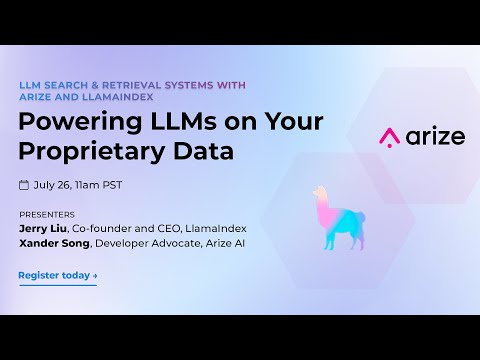

In [16]:
start_time_in_seconds = int(timedelta(hours=0, minutes=29, seconds=42).total_seconds())
YouTubeVideo("hbQYDpJayFw", start=start_time_in_seconds, width=560, height=315)